#### Description
This notebook is to analyze the testcase site_09253000

In [17]:
import xarray as xr
import glob
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0)) # CONUS
plot_proj = nwm_proj


#### Reading the SNOTEL observations from the .nc files

In [6]:

geo = xr.open_dataset('./site_09253000/Domain/GEOGRID_LDASOUT_Spatial_Metadata.nc')
xm = geo.x
ym = geo.y
def preprocess_owp_obs(ds):
    path = ds.encoding['source']
    ds0 = xr.open_dataset(path, group='MetaData')
    ds1 = xr.open_dataset(path, group='ObsValue').rename({'snow_water_equivalent':'SWE'})
    ds2 = xr.open_dataset(path, group='ObsError').rename({'snow_water_equivalent':'SWE_ERROR'})
    ds3 = xr.open_dataset(path, group='PreQC').rename({'snow_water_equivalent':'SWE_PreQC'})
    ds = xr.merge([ds0, ds1, ds2, ds3])
    
    tt = ds.datetime.values
    ttt = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ") for t in tt]
    date = ttt[0].date()
    # da = xr.DataArray(data=ttt, dims='ncols')
    # ds['ddd'] = da
    ds = ds.assign_coords(nlocs = ds.nlocs)
    ds = ds.expand_dims('date')
    
    # ds = ds.assign_coords({'datetime':("nlocs",ttt), 
    #                        'latitude':("nlocs",ds.latitude), 
    #                        'longitude':("nlocs",ds.longitude),
    #                        'height':("nlocs",ds.height),
    #                        'station_id':("nlocs", ds.station_id)})
    
    ds['date']=[date]
    return ds


files = sorted(glob.glob('./site_09253000/SNOTEL_obs/owp_swe*'))
obs_owp = xr.open_mfdataset(files, preprocess=preprocess_owp_obs) # open_mfdataset(files)
display(obs_owp)


<xarray.Dataset>
Dimensions:     (nlocs: 5, date: 9)
Coordinates:
  * nlocs       (nlocs) int64 0 1 2 3 4
  * date        (date) object 2021-03-01 2021-03-02 ... 2021-03-08 2021-03-09
Data variables:
    datetime    (date, nlocs) object '2021-03-01T10:00:00Z' ... nan
    height      (date, nlocs) float32 2.676e+03 2.652e+03 ... 2.728e+03 nan
    latitude    (date, nlocs) float32 40.8 40.85 41.07 41.11 ... 41.11 41.0 nan
    longitude   (date, nlocs) float32 -107.1 -107.0 -106.9 ... -107.2 -106.9 nan
    station_id  (date, nlocs) object 'EKDC2' 'ELKC2' 'LITW4' ... 'WPKW4' nan
    SWE         (date, nlocs) float32 320.0 340.4 505.5 ... 281.9 629.9 nan
    SWE_ERROR   (date, nlocs) float32 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 nan
    SWE_PreQC   (date, nlocs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan

#### Reshaping the xr object and add coordinates to the sites (i.e., change `nloc` to `lat` and `lon`, add time as coordinates, etc.)

In [12]:
ff = obs_owp.stack(n=('date','nlocs'))
vv = ff.station_id.values

list_sites = vv[~pd.isnull(vv)]
list_sites = np.unique(list_sites)
len(list_sites)

5

In [25]:

from tqdm import tqdm

list_ds = list()
for s in tqdm(list_sites):
    oo = obs_owp.where(obs_owp.station_id == s, drop=True)
    oos = oo.stack(z=('nlocs','date'))
    oos = oos.where(oos.datetime.notnull(), drop=True)
    oos = oos.sortby('datetime')
    
    oo_swe = oos.SWE.values
    oo_swe_er = oos.SWE_ERROR.values
    oo_swe_qc = oos.SWE_PreQC.values
    
    oo_datetime = oos.datetime.values
    oo_datetime2 = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ") for t in oo_datetime]
    oo_x = np.round(np.mean(np.unique(oos.longitude.values)), decimals=3)
    oo_y = np.round(np.mean(np.unique(oos.latitude.values)), decimals=3)
    oo_z = np.round(np.mean(np.unique(oos.height.values)), decimals=3)
    
    da1 = xr.DataArray(data=oo_swe, dims=["time"], coords=dict(time=("time", oo_datetime2))).rename('SWE')
    da2 = xr.DataArray(data=oo_swe_er, dims=["time"], coords=dict(time=("time", oo_datetime2))).rename('SWE_ERROR')
    da3 = xr.DataArray(data=oo_swe_qc, dims=["time"], coords=dict(time=("time", oo_datetime2))).rename('SWE_PreQC')
    ds = xr.merge([da1, da2, da3])
    # da = da.groupby('time.date').mean('time')
    # da['date'] = [datetime.combine(t, datetime.min.time()) for t in da.date.values]
    # print(s)
    # print(da)
    # print(oo_x, oo_y)
    ds = ds.expand_dims('station')
    ds = ds.assign_coords({"lon":("station", [oo_x]),
                           "lat":("station", [oo_y]),
                           "hgt":("station", [oo_z]),
                           "station_id":("station", [s])}
                         )
    
    list_ds.append(ds)


snotel_obs = xr.concat(list_ds, dim='station')
display(snotel_obs)

100%|██████████| 5/5 [00:00<00:00, 51.33it/s]


<xarray.Dataset>
Dimensions:     (time: 22, station: 5)
Coordinates:
  * time        (time) datetime64[ns] 2021-03-01T10:00:00 ... 2021-03-09T15:0...
    lon         (station) float32 -107.1 -107.0 -106.9 -107.2 -106.9
    lat         (station) float32 40.8 40.85 41.07 41.11 41.0
    hgt         (station) float32 2.676e+03 2.652e+03 ... 2.484e+03 2.728e+03
    station_id  (station) <U5 'EKDC2' 'ELKC2' 'LITW4' 'SRSW4' 'WPKW4'
Dimensions without coordinates: station
Data variables:
    SWE         (station, time) float32 320.0 nan 325.1 nan ... 629.9 nan nan
    SWE_ERROR   (station, time) float32 10.0 nan 10.0 nan ... nan 10.0 nan nan
    SWE_PreQC   (station, time) float32 0.0 nan 0.0 nan nan ... nan 0.0 nan nan

#### Loading geo_em file to visualize domain grid cells and elevation

In [33]:

geo_em = xr.open_dataset('./site_09253000/Domain/geo_em.d0x.nc')
geo_em = geo_em.drop_vars(set(geo_em.data_vars).difference(set(['HGT_M'])))
geo_em = geo_em.rename({'west_east':'x', 'south_north':'y'})
geo_em = geo_em.assign_coords({'x':xm, 'y':ym[::-1]})

display(geo_em)
# geo_em.HGT_M.plot()

<xarray.Dataset>
Dimensions:  (Time: 1, y: 34, x: 31)
Coordinates:
  * x        (x) float64 -8.265e+05 -8.255e+05 ... -7.975e+05 -7.965e+05
  * y        (y) float64 1.385e+05 1.395e+05 1.405e+05 ... 1.705e+05 1.715e+05
Dimensions without coordinates: Time
Data variables:
    HGT_M    (Time, y, x) float32 ...
Attributes: (12/49)
    TITLE:                           OUTPUT FROM GEOGRID V3.6
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        32
    SOUTH-NORTH_GRID_DIMENSION:      35
    BOTTOM-TOP_GRID_DIMENSION:       0
    WEST-EAST_PATCH_START_UNSTAG:    1
    ...                              ...
    NCO:                             netCDF Operators version 5.1.4 (Homepage...
    nco_openmp_thread_number:        1
    region:                          CONUS
    version:                         NWM v2.1
    history:                         Thu Jun 29 10:16:35 2023: ncatted -O -a ...
    history_of_appended_files:       Fri Jan  3 08:18:34 2020: Appended file ...

#### Plotting the domain map

CPU times: user 55.4 ms, sys: 0 ns, total: 55.4 ms
Wall time: 57.7 ms


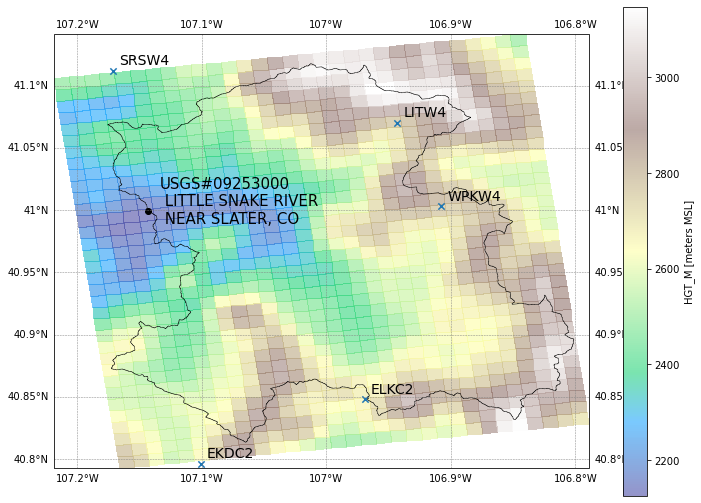

In [85]:
%%time

gage_lon = -107.143388
gage_lat = 40.99941048
gage_name = 'USGS#09253000\n LITTLE SNAKE RIVER\n NEAR SLATER, CO'
basin_boundary = ShapelyFeature(Reader('./site_09253000/Domain/basin_boundary/USGS_09253000.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')

lon_min = -107.5
lon_max = -106.5
lat_min = 40.5
lat_max = 41.5

plot_proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12,9))
ax1 = plt.axes(projection=plot_proj)
ax1.add_feature(basin_boundary, linewidth=.5)
plt.plot([gage_lon], [gage_lat], color='black', linewidth=2, marker='o', transform=ccrs.PlateCarree())
plt.text(gage_lon+.01, gage_lat-.01, gage_name,horizontalalignment='left',transform=ccrs.PlateCarree(), fontsize=15) 
geo_em.HGT_M.plot(ax=ax1, add_colorbar=True, cmap='terrain', alpha=0.52, transform=nwm_proj)
gl = ax1.gridlines(draw_labels=True, linewidth=.5, color='gray', alpha=.95, linestyle='--')

b_obs = snotel_obs
# b_obs = b_obs.where((b_obs.lat>lat_min) & (b_obs.lat<lat_max) & (b_obs.lon>lon_min) & (b_obs.lon<lon_max), drop=True).load()
d = b_obs.mean(dim='time') #.isel(time=1)

xr.plot.scatter(ax=ax1, ds=d, x='lon', y='lat', hue=None, marker='x', s=40, transform=ccrs.PlateCarree(), vmin=1, vmax=1, cbar_kwargs={'spacing': 'proportional'})
for i in range(len(d.station)):
    plt.text(d.lon.values[i]+.005, d.lat.values[i]+.005, d.station_id.values[i] ,horizontalalignment='left',transform=ccrs.PlateCarree(), fontsize=14)



**NOTE: 'x' markers indicate SNOTEL observation sites. There are two sites within the basin boundary and three nearby sites outside the boundary

## 
#### Plotting the timeseries of SNOTEL observations

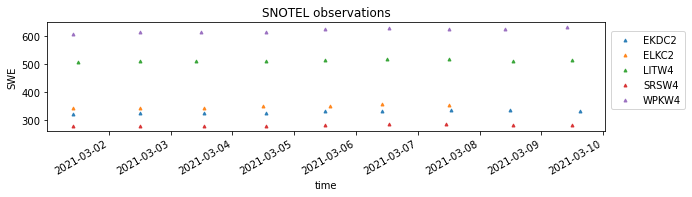

In [91]:
varname = 'SNEQV'
fig = plt.figure(figsize=(10,2))
for s in b_obs.station.values:
    obs_tmp = b_obs.sel(station=s)
    obs_tmp = obs_tmp.sel(time=slice('2021-03-01', '2021-10-01'))
    obs_tmp.SWE.plot.line(ls='none', marker='^', markersize='3', label=obs_tmp.station_id.values, alpha=0.86) #, yscale='log')

plt.title('SNOTEL observations')
plt.legend(loc=(1.01, 0.2), ncol=1)
# plt.ylim(60,120)
plt.show()